In [912]:
from IPython.display import display, Markdown

with open('README.md', 'r') as fh:
    content = fh.read()

display(Markdown(content))

# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: Web APIs & Classification

### Executive Summary

### Problem Statement

Reddit hosts threads on a massive variety of topics within their own categories.  I'm proposing
to train a classifier to distinguish between two wildly popular yet very different video game franchises:
God of War and The Legend of Zelda.  Both have enjoyed massive success and critical acclaim,
but the former is well known for violent enough to warrant an M-rating for every one of it's titles,
and the latter is whimsical and child-friendly.  Both also have their own lore and words unique to their
respective series.  I have selected two subrredits devoted to these series that consist mostly of text, 
as some subreddits consist mostly of pictures and video clips. 
	Before I start building models howeverI have to: first, scrape reddit for the data; second, clean
and format the data; and third, vectorize the cleaned text columns. I will use CountVectorize for this.
	After retrieving, cleaning, and processing the data, I will remove certain columns,
including the 'target' column, of course, from a 'features' list. The 'target' column, 
which contains a 1 or 0 (1 representing that the post came from theGod of War subreddit and 0 
representing that the post came from the Zelda subreddit), will be used as our y.
	Next, we will split the dataset into two: a training set, and a testing set.  By using
sklearn's train_test_split, we can check the results of our model when run on 'unseen' data,
giving us a more realistic test of the model's predictive power.
	Finally, we will run our data through the modeling process.  We will use four different
classification models: Logistic Regression, K Nearest Neighbors, Random Forests
and Naive Bayes.  I will also run the first three models through a gridsearch,
to tune hyper paramaters for each model to get a better feel for how well individual models may perform.
	Once all models have fitted, I will evaluate their accuracy scorings, find the strongest
performing model and declare it the model most worth pursuing further.


What I found was that the best performing model was Logistic Regression.  I Gridsearched
it and some of the parameters were: C = 1.3, penalty = L1.
	As I hypothesized these two subrredits don't have much overlap.  Since they are so different,
they were fairly easy to classify. In light of this I decided to remove certain words 
With this being the case, we decided to handicap the model, in a sense, by removing certain
words from the features.  This includes: Zelda, Legend, Kratos, God, and War.  
	After penalizing the model I still got very good accuracy for my models.  Logistic Regression did 
best with a Traning accuracy of 1.0 and a Test accuracy of 0.93. I also got a strong performance from
Random Forrests and Naive Bayes.  The former had 0.999 accuracy on the training set and 0.914 for the 
testing set, while the latter got 0.998 for the training set and 0.911 for the testing set.
having a Train Set Accuracy Score of .999 and a Test Set Accuracy Score of .950. The K Nearest Neighbors 
performed poorly, with a Train set accuracy of 0.709 and a Test set accuracy of 0.637. 
	In the future I'd like to see how these models work on different pairs of subreddits and
compare results.  Does the model work well on the GodofWar/Zelda subreddits,
or does it also work well on other subreddit pairs?

We recommend that reddit use my model to differentiate God of War reddit posts and Legend of Zelda posts.
The model works fairly well, but it will still misclassify 7 out of 100 posts. There is still room for 
improvement and I'd like to see how a Logistic Regression model would perfrom on a term frequency-inverse document frequency
vectorized dataset. 

In [821]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import html5lib
import json
import time
import regex as re
from bs4 import BeautifulSoup
from time import sleep

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils.multiclass import unique_labels

 

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

%matplotlib inline

In [797]:
#Is post about God of war or The Legend of Zelda?  

In [805]:
gow_url = 'https://www.reddit.com/r/GodofWar/'
z_url = 'https://www.reddit.com/r/truezelda/'
headers = {'User-Agent': 'General Assembly Student'}


In [799]:
res_z = requests.get('https://www.reddit.com/r/truezelda/.json', headers=headers)

In [800]:
res_z2.status_code

200

In [801]:
res_z.json();

In [802]:
headers = {'User-agent': 'General Assembly Student'}

In [9]:
res_g = requests.get(gowurl, headers=headers)

In [10]:
res_g.status_code

200

In [14]:
soup_g = BeautifulSoup(res_g.content, 'lxml')
soup_b = BeautifulSoup(res_b.content, 'lxml')

In [16]:
h1g = soup_g.find('h1')

In [17]:
type(h1g)

bs4.element.Tag

In [18]:
h1g.text

'GodofWar'

#### Want a function that will directly scrape a subreddit given the url and output a csv.  
##### 'reddit_to_csv' should take three arguments: 
##### 1) the subreddit being scraped
##### 2) A filename for the .csv to be produced
##### 3) the number of requests the user would like to make of reddit's API.

In [887]:
def reddit_to_csv(subreddit, filename, n_requests=30):
    #Initialize out list to hold all of the subreedit posts to be gathered
    posts = []
    
    #Make the 'after' key for last post None type for now
    after = None  
    
    #Create User-Agent to avoid 429 res.status_code:
    headers = {'User-Agent': 'General Assembly Student'}
    
    #for loop n_requests iterations where n is chosen by user:
    for i in range(n_requests):
       #Using the loop from Riley Dallas proj 3 info session
        
        if after == None:
            params = {}
        else:
            params = {'after': after}
            
        #Assign 'url' to subreddit base url plus .json
        url = str(subreddit) + '/.json'
        
        #Set my res variable equal to the results from requests.get, and the parameters set above like 'url' or 'params':
        res = requests.get(url, params = params, headers = headers)
        
        #only start the loop if we have a successful connection to the site
        if res.status_code == 200:
            
            the_json = res.json()
            
            for x in range(len(the_json['data']['children'])):
                
                #Create temp dict to contain results of posts to
                temp_dict = {}
                
                #Pick out the JSON info we need
                
                temp_dict['subreddit'] = the_json['data']['children'][x]['data']['subreddit']
                temp_dict['name'] = the_json['data']['children'][x]['data']['name']
                temp_dict['title'] = the_json['data']['children'][x]['data']['title']
                temp_dict['post_paragraph'] = the_json['data']['children'][x]['data']['selftext']
                temp_dict['score'] = the_json['data']['children'][x]['data']['score']
                temp_dict['subreddit_type'] = the_json['data']['children'][x]['data']['subreddit_type'] 
                temp_dict['link_flair_text'] = the_json['data']['children'][x]['data']['link_flair_text'] 
               
                
                #Add the temporary dictionary to 'posts',the list of each post's dictionary of information:
                posts.append(temp_dict)
                
            after = the_json['data']['after']
            
            #bookmark which pages I have already been parsed
            print(after)
            
        #If something went wrong when trying to connect print the status
        else:
            print(res.status_code)
            break
            
        #one second delay as scraper ethics demand  
        time.sleep(1)
        
        #let us know how many requests have been made
        print(i)
        

    #Finally convert our dictionaries of posts to dataframe
    posts_df = pd.DataFrame(posts)
    
    #Rearrange the columns
    posts_df = posts_df[['subreddit', 'name' ,'title', 'post_paragraph', 'score', 'subreddit_type', 'link_flair_text']]
    
    #Drop any duplicate rows that found it's way there
    posts_df.drop_duplicates(inplace = True)
    
    #At last save it all as a .csv
    posts_df.to_csv(str(filename), index = False, sep = ",")
    
    print("Successfully Scraped")   

In [414]:
#reddit_to_csv(gowurl, 'GoWposts3', n_requests=50)
#last after = t3_bml2oy 

In [31]:
gow1 = pd.read_csv('./data/GoWposts')

In [66]:
gow1.shape

(951, 7)

In [48]:
gow1.dtypes

subreddit          object
name               object
title              object
post_paragraph     object
score               int64
subreddit_type     object
link_flair_text    object
dtype: object

In [33]:
gow2 = pd.read_csv('./GoWposts2')

In [42]:
gow2.head()

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text
0,GodofWar,t3_a3wlrs,God of War = Game of the Year Megathread,God of War won in the following categories of ...,1655,public,NaN
1,GodofWar,t3_cayaif,Muspelheim sucks,I love muspelheim but man sometimes do I hate ...,96,public,NaN
2,GodofWar,t3_cb0q8u,Stuck on Muspelheim challenge,Playing the give me a challenge game mode and ...,19,public,NaN
3,GodofWar,t3_car8er,Possible cameo in the next games... (Spoilers),"In this game we see Jormungandr who, in Norse ...",297,public,NaN
4,GodofWar,t3_cay6dp,I just beat the last valkyrie,After hours of having much fun playing this ga...,31,public,Spoilers


In [57]:
df = pd.concat([gow1, gow2], ignore_index= True)

In [62]:
series = df.duplicated()

In [73]:
df.drop_duplicates(subset='post_paragraph', inplace=True)

In [74]:
df.to_csv('GoW_master', index = False)

In [71]:
df.shape

(1902, 7)

In [ ]:
gow_df.duplicated();

In [ ]:
god_df.drop_duplicates(keep=False).shape

In [ ]:
gow1.columns

In [ ]:
#reddit_to_csv(botwurl, 'Zeldaposts2', n_requests=29)

In [418]:
#reddit_to_csv(true_zelda_sub, 'true_zelda_reddit2', n_requests=29)

In [90]:
z = pd.read_csv('./true_zelda_reddit')

In [91]:
z.shape

(725, 7)

In [92]:
z.head()

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text
0,truezelda,t3_cb0ltc,What are some details/easter eggs/trivia in Wi...,I asked a similar question a while back [regar...,47,public,NaN
1,truezelda,t3_cb1ahn,New Blood Moon? (BotW2),What do you think will be the new blood moon m...,6,public,NaN
2,truezelda,t3_catrep,The New Champions Abilities,"So, the Champions were chosen for their abilit...",47,public,NaN
3,truezelda,t3_cau51l,Every The Legend of Zelda Spirit Battle Explai...,https://www.youtube.com/watch?v=B9MAPbuNvHs,29,public,NaN
4,truezelda,t3_careb3,Lomei vs. Zonai,Are these two the same? Just thought I’d get a...,36,public,NaN


In [98]:
series = z['name'].duplicated()

In [ ]:
zelda1['title'].duplicated()

In [ ]:
s1 = pd.merge(zelda1, zelda2, how='outer')

In [ ]:
s1.head()

In [ ]:
s1

In [ ]:
#Upon inspecting both subreddits I noticed a big difference between the two.  GoW posts was more discussion with text 
#but zelda had more pictures as posts with caption included.  

#if link_flair_text = 'NaN', 'Discussion', 'Question', 'News', 'Highlight', 'Spoilers'

In [ ]:
test2.link_flair_text.value_counts()

#### Combine datasets

In [102]:
gow_df = pd.read_csv('./data/GoWposts')

In [103]:
gow_df.head()

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text
0,GodofWar,t3_a3wlrs,God of War = Game of the Year Megathread,God of War won in the following categories of ...,1653,public,NaN
1,GodofWar,t3_car8er,Possible cameo in the next games... (Spoilers),"In this game we see Jormungandr who, in Norse ...",167,public,NaN
2,GodofWar,t3_cakipc,Valkyries,"I finally beat my first Valkyrie, I ascended t...",142,public,NaN
3,GodofWar,t3_canoeb,Best boss from each game,What do you think is the best boss from each g...,31,public,Spoilers
4,GodofWar,t3_cafsjf,WOMEN OF KRATOS,How many women in here that play GOW? Been pla...,277,public,NaN


In [104]:
gow_df.shape

(951, 7)

In [105]:
#same for zelda_df as above
z_df = pd.read_csv('./data/true_zelda_reddit')

In [106]:
z_df.shape

(725, 7)

In [107]:
z_df.head()

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text
0,truezelda,t3_cb0ltc,What are some details/easter eggs/trivia in Wi...,I asked a similar question a while back [regar...,47,public,NaN
1,truezelda,t3_cb1ahn,New Blood Moon? (BotW2),What do you think will be the new blood moon m...,6,public,NaN
2,truezelda,t3_catrep,The New Champions Abilities,"So, the Champions were chosen for their abilit...",47,public,NaN
3,truezelda,t3_cau51l,Every The Legend of Zelda Spirit Battle Explai...,https://www.youtube.com/watch?v=B9MAPbuNvHs,29,public,NaN
4,truezelda,t3_careb3,Lomei vs. Zonai,Are these two the same? Just thought I’d get a...,36,public,NaN


In [109]:
df = gow_df.append(z_df, ignore_index=True)

In [ ]:
#confirm everything is stacked properly

In [112]:
df.tail(3)

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text
1673,truezelda,t3_ad72cr,Which palaces and temples and places are the s...,"Especially in ALBW, which has the same overwor...",5,public,NaN
1674,truezelda,t3_ad2xj1,I really hope Ryo Nagamatsu becomes a mainstay...,Nagamatsu’s first work as the main music compo...,20,public,NaN
1675,truezelda,t3_acuo8g,I love Adventure of Link for its real fantasy ...,Don't get me wrong i'm really a zelda fan but ...,64,public,NaN


In [ ]:
# Create our target column

In [111]:
df.shape

(1676, 7)

In [115]:
#colum entry is 1 if post came from God of war subreddit, and zero if zelda 
df['target'] = np.where(df['subreddit'] == 'GodofWar', 1, 0)

In [116]:
df.head()

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text,target
0,GodofWar,t3_a3wlrs,God of War = Game of the Year Megathread,God of War won in the following categories of ...,1653,public,NaN,1
1,GodofWar,t3_car8er,Possible cameo in the next games... (Spoilers),"In this game we see Jormungandr who, in Norse ...",167,public,NaN,1
2,GodofWar,t3_cakipc,Valkyries,"I finally beat my first Valkyrie, I ascended t...",142,public,NaN,1
3,GodofWar,t3_canoeb,Best boss from each game,What do you think is the best boss from each g...,31,public,Spoilers,1
4,GodofWar,t3_cafsjf,WOMEN OF KRATOS,How many women in here that play GOW? Been pla...,277,public,NaN,1


In [ ]:
#Look for columns that don't have any values and can be dropped

In [121]:
df['post_paragraph'].isnull().sum()

41

In [120]:
#rows where post_paragraph = NaN only have titles for text.  Instead of dropping these rows, I will replace NaNs 
#empty strings
df['title'].isnull().sum()

0

In [123]:
df['post_paragraph'] = df.post_paragraph.fillna('')

In [141]:
df.head(n=10)

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text,target
0,GodofWar,t3_a3wlrs,God of War = Game of the Year Megathread,God of War won in the following categories of ...,1653,public,NaN,1
1,GodofWar,t3_car8er,Possible cameo in the next games... (Spoilers),"In this game we see Jormungandr who, in Norse ...",167,public,NaN,1
2,GodofWar,t3_cakipc,Valkyries,"I finally beat my first Valkyrie, I ascended t...",142,public,NaN,1
3,GodofWar,t3_canoeb,Best boss from each game,What do you think is the best boss from each g...,31,public,Spoilers,1
4,GodofWar,t3_cafsjf,WOMEN OF KRATOS,How many women in here that play GOW? Been pla...,277,public,NaN,1
5,GodofWar,t3_cau83n,Realm Tear Encounters in Niflheim - Worth it?,"So I've beaten the story, have the full Ivaldi...",3,public,NaN,1
6,GodofWar,t3_cav42a,The road to play platinum in God of War is the...,"The story is just incredible, and then afterwa...",3,public,NaN,1
7,GodofWar,t3_capukq,Valkyries,So I’m on the queen Valkyrie and I have no ide...,9,public,NaN,1
8,GodofWar,t3_casqc2,Vitality,"I really enjoy this fascinating game, but my g...",3,public,NaN,1
9,GodofWar,t3_cank69,I missed the Eye of the Outer Realm,I missed the Eye of the Outer Realm when in th...,11,public,NaN,1


In [149]:
#one last check for duplicates
df['name'].duplicated(keep = False).value_counts()

False    1676
Name: name, dtype: int64

In [154]:
df.iloc[1653]

subreddit                                                  truezelda
name                                                       t3_aeyd3o
title              Do we, around here at least, have a consensus ...
post_paragraph                                                      
score                                                             11
subreddit_type                                                public
link_flair_text                                                  NaN
target                                                             0
Name: 1653, dtype: object

In [151]:
temp = pd.DataFrame(df['post_paragraph'] != '')

In [836]:
df['post_paragraph'].duplicated(keep = False).value_counts()

False    1631
True       45
Name: post_paragraph, dtype: int64

In [839]:
df['target'].value_counts()

1    951
0    725
Name: target, dtype: int64

#### Base accuracy is  0.567

#### After cleaning convert to master .csv

In [155]:
df.to_csv('master_df.csv', index=False, sep=",")

## Commence with NLP

In [156]:
lemmatizer = WordNetLemmatizer()

In [166]:
tokenizer = RegexpTokenizer(r'\w+')

In [157]:
df = pd.read_csv('./master_df.csv')

In [158]:
df.columns

Index(['subreddit', 'name', 'title', 'post_paragraph', 'score',
       'subreddit_type', 'link_flair_text', 'target'],
      dtype='object')

In [254]:
df['post_paragraph'].isnull().sum()

41

In [255]:
df['post_paragraph'] = df['post_paragraph'].replace(np.nan, "")

In [256]:
df['post_paragraph'].isnull().sum()

0

In [257]:
df.head()

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text,target,title_clean,post_paragraph_clean
0,GodofWar,t3_a3wlrs,God of War = Game of the Year Megathread,God of War won in the following categories of ...,1653,public,NaN,1,game the year megathread,won in the following category game award game ...
1,GodofWar,t3_car8er,Possible cameo in the next games... (Spoilers),"In this game we see Jormungandr who, in Norse ...",167,public,NaN,1,possible cameo in the next game spoiler,in this game we see jormungandr who norse myth...
2,GodofWar,t3_cakipc,Valkyries,"I finally beat my first Valkyrie, I ascended t...",142,public,NaN,1,valkyrie,i finally beat my first valkyrie ascended the ...
3,GodofWar,t3_canoeb,Best boss from each game,What do you think is the best boss from each g...,31,public,Spoilers,1,best bos from each game,what do you think is the best bos from each ga...
4,GodofWar,t3_cafsjf,WOMEN OF KRATOS,How many women in here that play GOW? Been pla...,277,public,NaN,1,woman kratos,how many woman in here that play gow been play...


In [205]:
#need a function to remove cheat words, make lower case, and lemmatize and return a column
def column_cleaner(column, df=df):
    
    df[column+'_clean'] = ""
    
    #loop through each row in the column:
    for i in range(len(df[column])):
        
        #Tokenize each word in column's string into its own string
        col_tok = []
        col_tok.extend(tokenizer.tokenize(df[column][i].lower()))
        col_token = []
        [col_token.append(s) for s in col_tok if s not in col_token]
        
        #Lemmatize the words 
        col_lem = []
        for x in range(len(col_token)):
            col_lem.append(lemmatizer.lemmatize(col_token[x]))
        
        #get rid of numbers and special characters
        letters_only_col = []
        for c in range(len(col_lem)):
            letters_only_col.append(re.sub("[^a-zA-Z]", "", col_lem[c]))
        
        #get rid of stopwords 
        col_words = [w for w in letters_only_col if not w in stopwords.words('english')]
        
        #get rid of subreddit title words 
        cheat_words = ['god', 'of' ,'war', 'zelda']
        col_words = [w for w in letters_only_col if not w in cheat_words]
        
        #get rid of any 'None' objects that snuck in
        col_words = list(filter(None, col_words))

        #Join the lemmatized words - stopwords back to one long string (prep for
        #vectorization, done outside/after this function):
        col_words = " ".join(col_words)

        #Fill new column with 'cleaned' string from column:
        df[column+'_clean'][i] = col_words

In [172]:
column_cleaner(column='title', df=df)

/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [173]:
df['post_paragraph'].head()

0    God of War won in the following categories of ...
1    In this game we see Jormungandr who, in Norse ...
2    I finally beat my first Valkyrie, I ascended t...
3    What do you think is the best boss from each g...
4    How many women in here that play GOW? Been pla...
Name: post_paragraph, dtype: object

In [206]:
column_cleaner(column='post_paragraph', df=df)

/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [258]:
df['post_paragraph_clean'].isnull().sum()

41

In [259]:
df['post_paragraph_clean'] = df['post_paragraph_clean'].replace(np.nan, "")

In [260]:
df['post_paragraph_clean'].isnull().sum()

0

In [261]:
df.to_csv('master_df_cleaned.csv', index=False, sep=",")

In [569]:
df = pd.read_csv('./data/master_df_cleaned.csv')

In [281]:
df.head()

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text,target,title_clean,post_paragraph_clean
0,GodofWar,t3_a3wlrs,God of War = Game of the Year Megathread,God of War won in the following categories of ...,1653,public,NaN,1,game the year megathread,won in the following category game award game ...
1,GodofWar,t3_car8er,Possible cameo in the next games... (Spoilers),"In this game we see Jormungandr who, in Norse ...",167,public,NaN,1,possible cameo in the next game spoiler,in this game we see jormungandr who norse myth...
2,GodofWar,t3_cakipc,Valkyries,"I finally beat my first Valkyrie, I ascended t...",142,public,NaN,1,valkyrie,i finally beat my first valkyrie ascended the ...
3,GodofWar,t3_canoeb,Best boss from each game,What do you think is the best boss from each g...,31,public,Spoilers,1,best bos from each game,what do you think is the best bos from each ga...
4,GodofWar,t3_cafsjf,WOMEN OF KRATOS,How many women in here that play GOW? Been pla...,277,public,NaN,1,woman kratos,how many woman in here that play gow been play...


In [282]:
vect = CountVectorizer()

In [283]:
df['title_clean'] = df['title_clean'].replace(np.nan, "")

In [284]:
df['title_clean'].isnull().sum()

0

In [285]:
df['post_paragraph_clean'] = df['post_paragraph_clean'].replace(np.nan, "")

In [286]:
df['post_paragraph_clean'].isnull().sum()

0

In [287]:
X_text = vect.fit_transform(df['title_clean'])

In [288]:
X_text = X_text.toarray()

In [289]:
temp_df = pd.DataFrame(X_text,
        columns=vect.get_feature_names())

In [290]:
#Add the original column name to the beginning of the new columns' names to differentiate from which column
# the vectorized words came from (this may impact the strength of the model):
for i in range(len(temp_df.columns)):
    temp_df.rename(columns={temp_df.columns[i]: 'title' + '_' + temp_df.columns[i]}, inplace=True)

In [291]:
#Combine the two DataFrames:
df = pd.concat([df, temp_df], axis=1, join_axes=[df.index])
    

In [294]:
df.head(n=2)

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text,target,title_clean,post_paragraph_clean,...,title_zebes,title_zeld,title_zeldaless,title_zeldas,title_zeltik,title_zero,title_zeus,title_zombo,title_zonai,title_zora
0,GodofWar,t3_a3wlrs,God of War = Game of the Year Megathread,God of War won in the following categories of ...,1653,public,NaN,1,game the year megathread,won in the following category game award game ...,...,0,0,0,0,0,0,0,0,0,0
1,GodofWar,t3_car8er,Possible cameo in the next games... (Spoilers),"In this game we see Jormungandr who, in Norse ...",167,public,NaN,1,possible cameo in the next game spoiler,in this game we see jormungandr who norse myth...,...,0,0,0,0,0,0,0,0,0,0


In [296]:
df['post_paragraph'].isnull().sum()

41

In [298]:
df['post_paragraph'] = df['post_paragraph'].replace(np.nan, "")

In [299]:
#Do the same for post body
X_text = vect.fit_transform(df['post_paragraph_clean'])
X_text = X_text.toarray()
temp_df = pd.DataFrame(X_text,
        columns=vect.get_feature_names())
for i in range(len(temp_df.columns)):
    temp_df.rename(columns={temp_df.columns[i]: 'post_paragraph_clean' + '_' + temp_df.columns[i]}, inplace=True)

In [300]:
df = pd.concat([df, temp_df], axis=1, join_axes=[df.index])

In [301]:
df.columns

Index(['subreddit', 'name', 'title', 'post_paragraph', 'score',
       'subreddit_type', 'link_flair_text', 'target', 'title_clean',
       'post_paragraph_clean',
       ...
       'post_paragraph_clean_zoras', 'post_paragraph_clean_zou',
       'post_paragraph_clean_zrrpt', 'post_paragraph_clean_zrrt',
       'post_paragraph_clean_ztranslation', 'post_paragraph_clean_zubora',
       'post_paragraph_clean_zues', 'post_paragraph_clean_zuna',
       'post_paragraph_clean_zyaxif', 'post_paragraph_clean_zzbpcws'],
      dtype='object', length=15482)

In [302]:
len(df.columns)

15482

In [303]:
df.to_csv('master_df_cleaned_vectorized.csv', index=False, sep=",")

In [230]:
#tfidf_vect = TfidfVectorizer()

In [231]:
#Do the same thing as for countvectorize but for tf-idf
#X_text = tfidf_vect.fit_transform(df['title'])
#X_text = X_text.toarray()
    
#Create a temporary DataFrame with each word/word-pair/word-group as the columns:
#temp_df = pd.DataFrame(X_text,
#    columns=tfidf_vect.get_feature_names())
#for i in range(len(temp_df.columns)):
    #print(i)
#    temp_df.rename(columns={temp_df.columns[i]: 'title' + '_idf_' + temp_df.columns[i]}, inplace=True)

In [232]:
#df = pd.concat([df, temp_df], axis=1, join_axes=[df.index])

In [590]:
df = pd.read_csv('./data/master_df_cleaned_vectorized.csv')

/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [591]:
features = list(df.columns)

In [592]:
features[:10]

['subreddit',
 'name',
 'title',
 'post_paragraph',
 'score',
 'subreddit_type',
 'link_flair_text',
 'target',
 'title_clean',
 'post_paragraph_clean']

In [593]:
del_list = ['subreddit', 'target', 'title', 'title_clean', 'post_paragraph', 'post_paragraph_clean', 
            'name', 'score', 'subreddit_type', 'link_flair_text']

In [594]:
features = [i for i in features if i not in del_list]

In [595]:
features[:10]

['title_abandoned',
 'title_ability',
 'title_able',
 'title_about',
 'title_above',
 'title_abrams',
 'title_absence',
 'title_absolutely',
 'title_absurd',
 'title_accidentally']

In [596]:
X = df[features]
y = df['target']

In [788]:
y.value_counts()
print(725 / 951)

0.7623554153522608


In [597]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

#### Confusion matrix plotter (https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [915]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_test, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Modeling

#### Logistic Regression

In [598]:
logreg = LogisticRegression()

In [599]:
logreg.fit(X_train, y_train)

/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [600]:
cross_val_score(logreg, X_train, y_train, cv=5)

/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logisti

array([0.9484127 , 0.93253968, 0.93253968, 0.92031873, 0.956     ])

In [601]:
logreg.score(X_train, y_train)

1.0

In [602]:
logreg.score(X_test, y_test)

0.9307875894988067

In [785]:
weights = logreg.coef_
abs_weights = np.abs(weights)

print(abs_weights)

[[3.66213825e-02 3.19088240e-01 1.20347061e-01 ... 3.69000497e-06
  2.60333099e-03 3.98584424e-05]]


In [615]:
#get coefficients associated with each word
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(logreg.coef_))], axis = 1)

In [617]:
coefficients.columns = ['word', 'coefficient']

In [627]:
coefficients['coefficient'] = coefficients['coefficient'].abs()


In [796]:
#coefficients.sort_values(by = 'coefficient', ascending = False)
#largest values from post_paragraph_clean_kratos, title_link, titile_botw, post_paragraph_clean_botw,
#title_kratos, post_paragraph_clean_oot
coefficients.iloc

In [822]:
#let's drop these four top-valued features to see how it affects the model
#Upon dropping words associated with top 4 coeffecients training score did not change but test score dropped 

In [784]:
#X_trim = X.drop(columns = ['post_paragraph_clean_kratos', 'title_link', 'title_botw', 'post_paragraph_clean_botw'])

In [699]:
my_params = {
    'solver' : ['warn'],
    'penalty': ['l2'],
    'C': [1.1, 1.2, 1.3, 1.31, 1.32]
}

In [700]:
log_grid = GridSearchCV(logreg, param_grid=my_params, cv=5)

In [701]:
log_grid.fit(X_train, y_train)

/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eliregen/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logisti

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1.1, 1.2, 1.3, 1.31, 1.32], 'penalty': ['l2'],
                         'solver': ['warn']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [705]:
log_grid.score(X_train, y_train)

1.0

In [892]:
log_grid.best_params_

{'C': 1.3, 'penalty': 'l2', 'solver': 'warn'}

In [706]:
log_grid.score(X_test, y_test)

0.9307875894988067

In [827]:
y_pred_log = log_grid.predict(X_test)

In [843]:
confusion_matrix(y_test, y_pred_log)

array([[157,  24],
       [  5, 233]])

In [707]:
log_grid.best_params_

{'C': 1.3, 'penalty': 'l2', 'solver': 'warn'}

In [909]:
data = {'  ':['Model', 'Vectorization', 'CV Folds', 'Parameter_1', 'Parameter_2', 'Train Set Score', 'Test Set Score'],  
        '  ':['Logistic Regression', 'CountVectorize', 'C = 1.3', 'Penalty = l2', '1.0', '0.93079']} 
logistic_data = pd.DataFrame(data) 


In [910]:
logistic_data

,
0,Logistic Regression
1,CountVectorize
2,C = 1.3
3,Penalty = l2
4,1.0
5,0.93079


Confusion matrix, without normalization
[[157  24]
 [  5 233]]


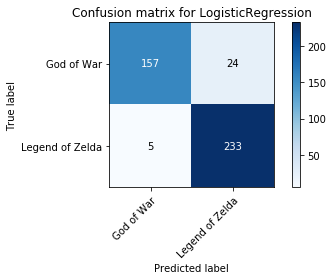

In [923]:

# Plot non-normalized confusion matrix
conufslog = plot_confusion_matrix(y_test, y_pred_log, classes=['God of War', 'Legend of Zelda'],
                      title='Confusion matrix for LogisticRegression')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()


#### Nearest Neighbors

In [668]:
knn = KNeighborsClassifier()

In [669]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [670]:
cross_val_score(knn, X_train, y_train, cv = 5)

array([0.58730159, 0.65873016, 0.63095238, 0.6374502 , 0.608     ])

In [672]:
knn.score(X_train, y_train)

0.7629276054097056

In [671]:
knn.score(X_test, y_test)

0.6587112171837709

In [845]:
y_pred_knn = knn.predict(X_test)

In [846]:
confusion_matrix(y_pred_knn, y_test)

array([[ 67,  29],
       [114, 209]])

In [717]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [741]:
my_params = {
    'n_neighbors': [5, 7, 10],
    'weights': ['uniform'],
    'leaf_size': [10, 15, 25, 30]
}

In [742]:
grid_knn = GridSearchCV(knn, param_grid=my_params, cv=5)

In [743]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'leaf_size': [10, 15, 25, 30],
                         'n_neighbors': [5, 7, 10], 'weights': ['uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [744]:
grid_knn.score(X_train, y_train)

0.7088305489260143

In [745]:
grid_knn.score(X_test, y_test)

0.6372315035799523

In [746]:
grid_knn.best_params_ 

{'leaf_size': 10, 'n_neighbors': 10, 'weights': 'uniform'}

Confusion matrix, without normalization
[[ 67 114]
 [ 29 209]]


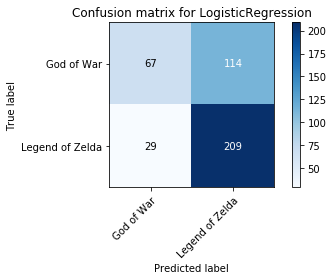

In [925]:
# Plot non-normalized confusion matrix
conufsknn = plot_confusion_matrix(y_test, y_pred_knn, classes=['God of War', 'Legend of Zelda'],
                      title='Confusion matrix for LogisticRegression')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()


#### Random Forest Classifier

In [747]:
rf = RandomForestClassifier()

In [853]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [854]:
cross_val_score(rf, X_train, y_train, cv = 5)

array([0.86111111, 0.8968254 , 0.88492063, 0.91633466, 0.92      ])

In [855]:
rf.score(X_train, y_train)

0.9992044550517104

In [856]:
rf.score(X_test, y_test)

0.9021479713603818

In [857]:
y_pred_rf = rf.predict(X_test)

In [858]:
confusion_matrix(y_test, y_pred_rf)

array([[155,  26],
       [ 15, 223]])

Confusion matrix, without normalization
[[155  26]
 [ 15 223]]


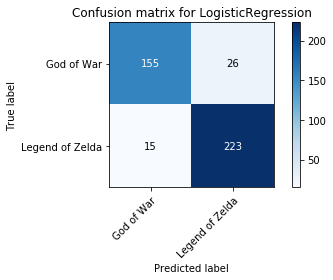

In [926]:
# Plot non-normalized confusion matrix
conufsknn = plot_confusion_matrix(y_test, y_pred_rf, classes=['God of War', 'Legend of Zelda'],
                      title='Confusion matrix for LogisticRegression')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()


In [859]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [100, 104, 105, 106],
    'min_samples_split': [2, 3, 4],
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

0.9172633253778838


{'min_samples_split': 2, 'n_estimators': 106}

In [864]:
gs_rf.score(X_train, y_train)

1.0

In [865]:
gs_rf.score(X_test, y_test)

0.9140811455847255

In [869]:
y_pred_gs = gs.predict(X_test)

In [871]:
confusion_matrix(y_test, y_pred_gs)

array([[152,  29],
       [  2, 236]])

In [861]:
rf_n = RandomForestClassifier(min_samples_split = 2, n_estimators = 106)

In [862]:
rf_n.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=106,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [863]:
cross_val_score(rf_n, X_train, y_train, cv = 5)

array([0.91666667, 0.92857143, 0.90079365, 0.89641434, 0.932     ])

In [872]:
rf_n.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=106,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [873]:
rf_n.score(X_train, y_train)

1.0

In [874]:
rf_n.score(X_test, y_test)

0.9307875894988067

In [875]:
y_pred_rf_n = rf_n.predict(X_test)

In [876]:
confusion_matrix(y_test, y_pred_rf_n)

array([[155,  26],
       [  3, 235]])

#### Naive Bayes classifier

In [811]:
from sklearn.naive_bayes import GaussianNB

In [812]:
gnb = GaussianNB()

In [814]:
cross_val_score(gnb, X_train, y_train, cv = 5)

array([0.86507937, 0.88492063, 0.86111111, 0.90039841, 0.932     ])

In [816]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [817]:
gnb.score(X_train, y_train)

0.9976133651551312

In [818]:
gnb.score(X_test, y_test)

0.9116945107398569

In [ ]:
gnb

In [877]:
y_pred_gnb = gnb.predict(X_test)

In [879]:
confusion_matrix(y_pred_gnb, y_test)

array([[174,  30],
       [  7, 208]])

Confusion matrix, without normalization
[[174   7]
 [ 30 208]]


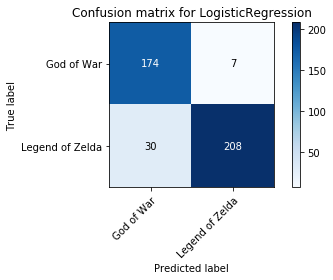

In [927]:
# Plot non-normalized confusion matrix
conufsknn = plot_confusion_matrix(y_test, y_pred_gnb, classes=['God of War', 'Legend of Zelda'],
                      title='Confusion matrix for LogisticRegression')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()


#### TF-IDF feature engineering

In [546]:
data = pd.read_csv("./data/master_df_cleaned.csv")

In [547]:
data.head(n=2)

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text,target,title_clean,post_paragraph_clean
0,GodofWar,t3_a3wlrs,God of War = Game of the Year Megathread,God of War won in the following categories of ...,1653,public,NaN,1,game the year megathread,won in the following category game award game ...
1,GodofWar,t3_car8er,Possible cameo in the next games... (Spoilers),"In this game we see Jormungandr who, in Norse ...",167,public,NaN,1,possible cameo in the next game spoiler,in this game we see jormungandr who norse myth...


In [548]:
data['post_paragraph'] = data['post_paragraph'].replace(np.nan, "")

In [549]:
data['title_clean'] = data['title_clean'].replace(np.nan, "")

In [550]:
data['post_paragraph_clean'] = data['post_paragraph_clean'].replace(np.nan, "")

In [551]:
data.isnull().sum()

subreddit                  0
name                       0
title                      0
post_paragraph             0
score                      0
subreddit_type             0
link_flair_text         1548
target                     0
title_clean                0
post_paragraph_clean       0
dtype: int64

In [552]:
#Do the same thing as for countvectorize but for tfidf
X_text = tfidf_vect.fit_transform(data['title_clean'])
X_text = X_text.toarray()
    
#Create a temporary DataFrame with each word/word-pair/word-group as the columns:
temp_data = pd.DataFrame(X_text,
columns=tfidf_vect.get_feature_names())
for i in range(len(temp_data.columns)):
    #print(i)
    temp_data.rename(columns={temp_data.columns[i]: 'title_clean' + '_idf_' + temp_data.columns[i]}, inplace=True)

In [553]:
data = pd.concat([data, temp_data], axis=1, join_axes=[data.index])

In [554]:
data.head(n=1)

,subreddit,name,title,post_paragraph,score,subreddit_type,link_flair_text,target,title_clean,post_paragraph_clean,...,title_clean_idf_zebes,title_clean_idf_zeld,title_clean_idf_zeldaless,title_clean_idf_zeldas,title_clean_idf_zeltik,title_clean_idf_zero,title_clean_idf_zeus,title_clean_idf_zombo,title_clean_idf_zonai,title_clean_idf_zora
0,GodofWar,t3_a3wlrs,God of War = Game of the Year Megathread,God of War won in the following categories of ...,1653,public,NaN,1,game the year megathread,won in the following category game award game ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [555]:
#Do the same thing post body
X_text = tfidf_vect.fit_transform(data['post_paragraph_clean'])
X_text = X_text.toarray()
    
#Create a temporary DataFrame with each word/word-pair/word-group as the columns:
temp_data = pd.DataFrame(X_text,
columns=tfidf_vect.get_feature_names())
for i in range(len(temp_data.columns)):
    #print(i)
    temp_data.rename(columns={temp_data.columns[i]: 'post_paragraph_clean' + '_idf_' + temp_data.columns[i]}, inplace=True)

In [579]:
df = pd.read_csv('./data/master_df_cleaned_tf_idf.csv')

In [885]:
info = pd.DataFrame(columns=['post traits scraped'], data = ['subreddit', 'title', 'score', 'post paragraph', 'link_flair_text'])

In [886]:
info

,post traits scraped
0,subreddit
1,title
2,score
3,post paragraph
4,link_flair_text
